In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', 500)

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read the main data set
df=pd.read_csv('estimation_file.csv',
                    encoding='utf-8')


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (5,144) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [5]:
# exclude problematic data
old_len = len(df)
df = df[df['VRM_ADJ']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with missing VRM') 

# exclude problematic data
old_len = len(df)
df = df[df['FARE_per_UPT_2018']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with zero or negative fare') 

# exclude problematic data
old_len = len(df)
df = df[df['FARE_per_UPT_2018']<20]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with fare greater than $20') 

# exclude problematic data
old_len = len(df)
df = df[df['HH_0Veh']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with negative 0 veh HH') 


Excluding 0 records with missing VRM
Excluding 78 records with zero or negative fare
Excluding 11 records with fare greater than $20
Excluding 30 records with negative 0 veh HH


In [6]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [7]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']

# percent of population in transit supportive density
df['TSD_POP_PCT'] = df['POP_CENSUSTRACT'] / df['Tot_Pop']

# percent of pop born outside USA
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100


In [8]:
# mode specific effects

df['Bus_VRM_ADJ_RAIL']  = df['Bus_VRM_ADJ'] * df['RAIL_FLAG']
df['Rail_VRM_ADJ_BUS'] = df['Rail_VRM_ADJ']  * df['BUS_FLAG']

df['Bus_VRM_ADJ_RAIL_log'] = np.log(1+df['Bus_VRM_ADJ_RAIL'])
df['Rail_VRM_ADJ_BUS_log'] = np.log(1+df['Rail_VRM_ADJ_BUS'])


In [9]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [10]:
# calculate bus vs rail stuff

# various bus/rail specifics

df['TNC_FLAG_BUS'] = df['TNC_FLAG'] * df['BUS_FLAG']
df['TNC_FLAG_RAIL'] = df['TNC_FLAG'] * df['RAIL_FLAG']

df['YEARS_SINCE_TNC_BUS'] = df['YEARS_SINCE_TNC'] * df['BUS_FLAG']
df['YEARS_SINCE_TNC_RAIL'] = df['YEARS_SINCE_TNC'] * df['RAIL_FLAG']

df['dockless_flag'] = df['dockCt'].apply(lambda x : min(x,1))
df['scooter_flag']  = df['scooterCt'].apply(lambda x : min(x,1))

df['BIKE_SHARE'] = df['PBS_Flag'] + df['dockless_flag']
df['BIKE_SHARE'] = df['BIKE_SHARE'].apply(lambda x : min(x,1))


df['PBS_Flag_BUS']   = df['PBS_Flag']   * df['BUS_FLAG']
df['dockCt_BUS']     = df['dockCt']     * df['BUS_FLAG']
df['docklessCt_BUS'] = df['docklessCt'] * df['BUS_FLAG']
df['scooterCt_BUS']  = df['scooterCt']  * df['BUS_FLAG']
df['dockless_flag_BUS'] = df['dockless_flag'] * df['BUS_FLAG']
df['scooter_flag_BUS']  = df['scooter_flag']  * df['BUS_FLAG']
df['BIKE_SHARE_BUS']  = df['BIKE_SHARE']  * df['BUS_FLAG']


df['PBS_Flag_RAIL']   = df['PBS_Flag']   * df['RAIL_FLAG']
df['dockCt_RAIL']     = df['dockCt']     * df['RAIL_FLAG']
df['docklessCt_RAIL'] = df['docklessCt'] * df['RAIL_FLAG']
df['scooterCt_RAIL']  = df['scooterCt']  * df['RAIL_FLAG']
df['dockless_flag_RAIL'] = df['dockless_flag'] * df['RAIL_FLAG']
df['scooter_flag_RAIL']  = df['scooter_flag']  * df['RAIL_FLAG']
df['BIKE_SHARE_RAIL']  = df['BIKE_SHARE']  * df['RAIL_FLAG']




In [11]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [12]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [13]:
# create a log of all fields
for col in df.columns:
    df[col+'_log'] = np.log(df[col]+1)
    

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [14]:
# calculate lags

ids = df.index.get_level_values(0).unique()
for id in ids: 
    df2 = df.loc[id]
    
    for col in df.columns:
        df2[col + '_lag1'] = df2[col].shift(1)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: 

In [15]:
df[['UPT_ADJ', 'UPT_ADJ_lag1']]

KeyError: "['UPT_ADJ_lag1'] not in index"

In [ ]:
df.to_csv('temp.csv')

In [ ]:
# check the data
df.head()

## Some core model specification tests -- looking at traditional factors

In [16]:
# no time trends

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5449
Estimator:                   PanelOLS   R-squared (Between):              0.9974
No. Observations:                4173   R-squared (Within):               0.5449
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9972
Time:                        13:32:08   Log-likelihood                    836.76
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      777.95
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(6,3899)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             777.95
                            

In [17]:
# with inflation adjusted prices

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6086
Estimator:                   PanelOLS   R-squared (Between):              0.9957
No. Observations:                4173   R-squared (Within):               0.6086
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9959
Time:                        13:32:15   Log-likelihood                    1151.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1010.3
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(6,3899)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             1010.3
                            

In [18]:
# separate pop and emp


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + Tot_Pop_log \
                    + TOT_EMP_MSA_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6115
Estimator:                   PanelOLS   R-squared (Between):              0.9954
No. Observations:                4173   R-squared (Within):               0.6115
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9952
Time:                        13:33:05   Log-likelihood                    1166.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      876.31
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(7,3898)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             876.31
                            

In [19]:
# add average speed

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + AVG_SPEED_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6130
Estimator:                   PanelOLS   R-squared (Between):              0.9980
No. Observations:                4173   R-squared (Within):               0.6130
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9980
Time:                        13:33:17   Log-likelihood                    1175.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      882.17
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(7,3898)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             882.17
                            

In [20]:
# add average speed

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + AVG_SPEED \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6087
Estimator:                   PanelOLS   R-squared (Between):              0.9958
No. Observations:                4173   R-squared (Within):               0.6087
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9961
Time:                        13:33:23   Log-likelihood                    1151.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      866.15
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(7,3898)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             866.15
                            

In [21]:
# VRH and VRM

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + VRH_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6109
Estimator:                   PanelOLS   R-squared (Between):              0.9969
No. Observations:                4173   R-squared (Within):               0.6109
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9970
Time:                        13:33:28   Log-likelihood                    1163.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      874.14
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(7,3898)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             874.14
                            

In [22]:
# VRH and VRM

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRH_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5114
Estimator:                   PanelOLS   R-squared (Between):              0.9977
No. Observations:                4173   R-squared (Within):               0.5114
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9977
Time:                        13:33:28   Log-likelihood                    688.65
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      680.11
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(6,3899)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             680.11
                            

## look at lagging the VRM and the Fares

In [23]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6086
Estimator:                   PanelOLS   R-squared (Between):              0.9957
No. Observations:                4173   R-squared (Within):               0.6086
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9959
Time:                        13:33:29   Log-likelihood                    1151.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1010.3
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(6,3899)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             1010.3
                            

## Look at demographics

In [24]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6086
Estimator:                   PanelOLS   R-squared (Between):              0.9957
No. Observations:                4173   R-squared (Within):               0.6086
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9959
Time:                        13:33:33   Log-likelihood                    1151.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1010.3
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(6,3899)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             1010.3
                            

In [25]:
# income percentages

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + INC_U35 \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6087
Estimator:                   PanelOLS   R-squared (Between):              0.9982
No. Observations:                4173   R-squared (Within):               0.6087
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9983
Time:                        13:33:39   Log-likelihood                    1152.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      866.39
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(7,3898)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             866.39
                            

In [26]:
# income percentages

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + INC_100P \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6086
Estimator:                   PanelOLS   R-squared (Between):              0.9949
No. Observations:                4173   R-squared (Within):               0.6086
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9952
Time:                        13:33:44   Log-likelihood                    1151.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      865.79
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(7,3898)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             865.79
                            

In [27]:
# median income


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + HH_MED_INC_2018 \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6088
Estimator:                   PanelOLS   R-squared (Between):              0.9952
No. Observations:                4173   R-squared (Within):               0.6088
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9955
Time:                        13:33:47   Log-likelihood                    1152.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      866.52
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(7,3898)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             866.52
                            

In [28]:
# median income -- log


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + HH_MED_INC_2018_log \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6088
Estimator:                   PanelOLS   R-squared (Between):              0.9984
No. Observations:                4173   R-squared (Within):               0.6088
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9984
Time:                        13:33:53   Log-likelihood                    1152.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      866.58
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(7,3898)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             866.58
                            

In [29]:
# mean income


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + HH_MEAN_INC_2018 \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6102
Estimator:                   PanelOLS   R-squared (Between):              0.9919
No. Observations:                4173   R-squared (Within):               0.6102
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9923
Time:                        13:33:59   Log-likelihood                    1160.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      871.87
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(7,3898)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             871.87
                            

In [30]:
# mean income - log


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + HH_MEAN_INC_2018_log \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6105
Estimator:                   PanelOLS   R-squared (Between):              0.9902
No. Observations:                4173   R-squared (Within):               0.6105
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9899
Time:                        13:34:02   Log-likelihood                    1161.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      872.82
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(7,3898)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             872.82
                            

In [31]:
# median personal income

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + PCT_HH_NO_VEH \
                    + TOTAL_MED_INC_INDIV_2018 \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6115
Estimator:                   PanelOLS   R-squared (Between):              0.9984
No. Observations:                4173   R-squared (Within):               0.6115
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9984
Time:                        13:34:05   Log-likelihood                    1167.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      876.50
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(7,3898)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             876.50
                            

In [32]:
# median personal income - log

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6132
Estimator:                   PanelOLS   R-squared (Between):              0.9413
No. Observations:                4173   R-squared (Within):               0.6132
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9410
Time:                        13:34:10   Log-likelihood                    1176.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      882.73
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(7,3898)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             882.73
                            

In [33]:
# immigrant population

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6136
Estimator:                   PanelOLS   R-squared (Between):              0.9482
No. Observations:                4173   R-squared (Within):               0.6136
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9479
Time:                        13:34:25   Log-likelihood                    1178.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      773.55
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(8,3897)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             773.55
                            

In [34]:
# immigrant population - log

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6151
Estimator:                   PanelOLS   R-squared (Between):              0.9706
No. Observations:                4128   R-squared (Within):               0.6151
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9703
Time:                        13:34:29   Log-likelihood                    1282.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      769.41
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.403   Distribution:                  F(8,3852)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             769.41
                            

In [35]:
# immigrant population percentage
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6138
Estimator:                   PanelOLS   R-squared (Between):              0.9337
No. Observations:                4173   R-squared (Within):               0.6138
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9335
Time:                        13:34:30   Log-likelihood                    1179.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      774.36
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(8,3897)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             774.36
                            

## bus vs rail competion

In [36]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6138
Estimator:                   PanelOLS   R-squared (Between):              0.9337
No. Observations:                4173   R-squared (Within):               0.6138
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9335
Time:                        13:34:37   Log-likelihood                    1179.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      774.36
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(8,3897)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             774.36
                            

In [37]:
# include VRM on competing modes
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + Bus_VRM_ADJ_RAIL \
                    + Rail_VRM_ADJ_BUS \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


ValueError: exog does not have full column rank.

## TNCs, bikes, scooters

In [38]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6138
Estimator:                   PanelOLS   R-squared (Between):              0.9337
No. Observations:                4173   R-squared (Within):               0.6138
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9335
Time:                        13:34:42   Log-likelihood                    1179.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      774.36
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                  F(8,3897)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             774.36
                            

In [39]:
# add TNC flag

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + TNC_FLAG_BUS \
                    + TNC_FLAG_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6143
Estimator:                   PanelOLS   R-squared (Between):              0.9481
No. Observations:                4173   R-squared (Within):               0.6143
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9478
Time:                        13:34:52   Log-likelihood                    1182.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      620.47
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                 F(10,3895)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             620.47
                            

In [40]:
# add TNC flag

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6185
Estimator:                   PanelOLS   R-squared (Between):              0.9753
No. Observations:                4173   R-squared (Within):               0.6185
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9750
Time:                        13:34:55   Log-likelihood                    1205.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      631.60
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                 F(10,3895)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             631.60
                            

In [41]:
# add BIKE SHARE

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6166
Estimator:                   PanelOLS   R-squared (Between):              0.9984
No. Observations:                3962   R-squared (Within):               0.6166
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9984
Time:                        13:34:58   Log-likelihood                    1183.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      495.50
Entities:                         253   P-value                           0.0000
Avg Obs:                       15.660   Distribution:                 F(12,3697)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             495.50
                            

In [42]:
# add SCOOTERS

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6169
Estimator:                   PanelOLS   R-squared (Between):              0.9982
No. Observations:                3962   R-squared (Within):               0.6169
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9982
Time:                        13:35:01   Log-likelihood                    1184.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      424.91
Entities:                         253   P-value                           0.0000
Avg Obs:                       15.660   Distribution:                 F(14,3695)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             424.91
                            

In [43]:
# add dock count

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + dockCt_BUS \
                    + dockCt_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6189
Estimator:                   PanelOLS   R-squared (Between):              0.9781
No. Observations:                4173   R-squared (Within):               0.6189
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9778
Time:                        13:35:04   Log-likelihood                    1207.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      451.34
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.571   Distribution:                 F(14,3891)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             451.34
                            

In [44]:
# current favorite

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6169
Estimator:                   PanelOLS   R-squared (Between):              0.9982
No. Observations:                3962   R-squared (Within):               0.6169
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9982
Time:                        13:35:08   Log-likelihood                    1184.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      424.91
Entities:                         253   P-value                           0.0000
Avg Obs:                       15.660   Distribution:                 F(14,3695)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             424.91
                            

In [45]:
# bike share plus scooters for rail
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6168
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                3962   R-squared (Within):               0.6168
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9983
Time:                        13:35:11   Log-likelihood                    1184.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      457.62
Entities:                         253   P-value                           0.0000
Avg Obs:                       15.660   Distribution:                 F(13,3696)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             457.62
                            

In [54]:
# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6168
Estimator:                   PanelOLS   R-squared (Between):              0.9982
No. Observations:                3962   R-squared (Within):               0.6168
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9983
Time:                        13:38:48   Log-likelihood                    1184.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      457.67
Entities:                         253   P-value                           0.0000
Avg Obs:                       15.660   Distribution:                 F(13,3696)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             457.67
                            

## try time effects

In [63]:
# no time effects

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6168
Estimator:                   PanelOLS   R-squared (Between):              0.9982
No. Observations:                3962   R-squared (Within):               0.6168
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9983
Time:                        13:48:45   Log-likelihood                    1184.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      457.67
Entities:                         253   P-value                           0.0000
Avg Obs:                       15.660   Distribution:                 F(13,3696)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             457.67
                            

In [64]:
# full time effects

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + EntityEffects \
                    + TimeEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5667
Estimator:                   PanelOLS   R-squared (Between):              0.9883
No. Observations:                3962   R-squared (Within):               0.6119
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9887
Time:                        13:49:07   Log-likelihood                    1234.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      370.17
Entities:                         253   P-value                           0.0000
Avg Obs:                       15.660   Distribution:                 F(13,3680)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             370.17
                            

In [65]:
# trends

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + YEARS_SINCE_2002_BUS \
                    + YEARS_SINCE_2002_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6202
Estimator:                   PanelOLS   R-squared (Between):              0.9968
No. Observations:                3962   R-squared (Within):               0.6202
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9966
Time:                        13:54:46   Log-likelihood                    1202.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      402.18
Entities:                         253   P-value                           0.0000
Avg Obs:                       15.660   Distribution:                 F(15,3694)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             402.18
                            

In [66]:
# split trends

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + YEARS_2002_2014_BUS \
                    + YEARS_2002_2014_RAIL \
                    + YEARS_AFTER_2014_BUS \
                    + YEARS_AFTER_2014_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6267
Estimator:                   PanelOLS   R-squared (Between):              0.9981
No. Observations:                3962   R-squared (Within):               0.6267
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9981
Time:                        13:58:29   Log-likelihood                    1236.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      364.61
Entities:                         253   P-value                           0.0000
Avg Obs:                       15.660   Distribution:                 F(17,3692)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             364.61
                            

In [67]:
# it looks best without the time effects

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6168
Estimator:                   PanelOLS   R-squared (Between):              0.9982
No. Observations:                3962   R-squared (Within):               0.6168
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9983
Time:                        13:59:29   Log-likelihood                    1184.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      457.67
Entities:                         253   P-value                           0.0000
Avg Obs:                       15.660   Distribution:                 F(13,3696)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             457.67
                            

## Run some analytics

In [55]:
# bike share plus scooters for rail

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SCOOTER_SCOOTER_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6168
Estimator:                   PanelOLS   R-squared (Between):              0.9982
No. Observations:                3962   R-squared (Within):               0.6168
Date:                Thu, Nov 21 2019   R-squared (Overall):              0.9983
Time:                        13:39:34   Log-likelihood                    1184.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      457.67
Entities:                         253   P-value                           0.0000
Avg Obs:                       15.660   Distribution:                 F(13,3696)
Min Obs:                       2.0000                                           
Max Obs:                       17.000   F-statistic (robust):             457.67
                            

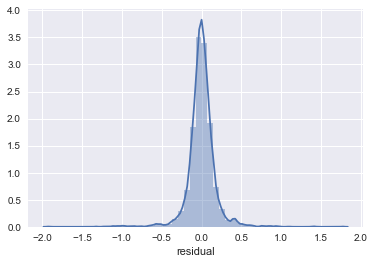

In [56]:
sns.distplot(res.resids)

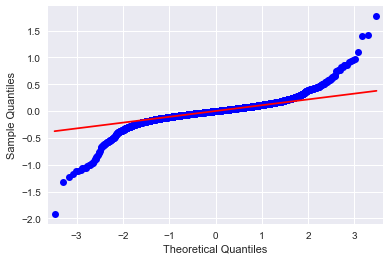

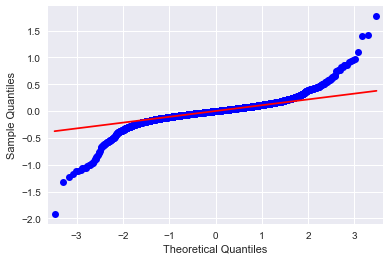

In [57]:
sm.graphics.qqplot(res.resids,line = 'q')

## Calculate FAC

In [58]:
# keep the relevant fields in the data set
app_data = pd.concat([df[['RAIL_FLAG', 'CLUSTER_APTA']], 
                      res.model.dependent.dataframe, 
                      res.model.exog.dataframe, 
                      res.estimated_effects, 
                      res.resids], axis=1)


In [59]:
app_data.head()

RAIL_FLAG  CLUSTER_APTA  UPT_ADJ_log  \
Akron, OH Metro Area-Bus 2002          0          24.0    15.469231   
                         2003          0          24.0    15.501150   
                         2004          0          24.0    15.591676   
                         2005          0          24.0    15.609548   
                         2006          0          24.0    15.619001   

                               VRM_ADJ_log  FARE_per_UPT_2018_log  \
Akron, OH Metro Area-Bus 2002    15.208377               0.162997   
                         2003    15.195930               0.502067   
                         2004    15.277699               0.450106   
                         2005    15.214971               0.499830   
                         2006    15.200501               0.501551   

                               POP_EMP_log  GAS_PRICE_2018_log  \
Akron, OH Metro Area-Bus 2002    13.808216            1.066089   
                         2003    13.823451            1.138954   
                         2004    13.839439            1.233697   
                         2005    13.857195            1.361617   
                         2006    13.879496            1.429114   

                               TOTAL_MED_INC_INDIV_2018_log  \
Akron, OH Metro Area-Bus 2002                     10.479210   
                         2003                     10.446267   
                         2004                     10.403980   
                         2005                     10.365663   
                         2006                     10.305856   

                               Tot_NonUSA_POP_pct  PCT_HH_NO_VEH  TSD_POP_PCT  \
Akron, OH Metro Area-Bus 2002           -0.060245           8.60     0.185260   
                         2003            0.114214           8.20     0.180770   
                         2004            0.288851           7.79     0.176377   
                         2005            0.430267           7.47     0.172435   
                         2006            0.669812           6.85     0.167543   

                               YEARS_SINCE_TNC_BUS  YEARS_SINCE_TNC_RAIL  \
Akron, OH Metro Area-Bus 2002                  0.0                   0.0   
                         2003                  0.0                   0.0   
                         2004                  0.0                   0.0   
                         2005                  0.0                   0.0   
                         2006                  0.0                   0.0   

                               BIKE_SHARE_BUS  scooter_flag_BUS  \
Akron, OH Metro Area-Bus 2002             0.0               0.0   
                         2003             0.0               0.0   
                         2004             0.0               0.0   
                         2005             0.0               0.0   
                         2006             0.0               0.0   

                               BIKE_SCOOTER_SCOOTER_RAIL   effects  residual  
Akron, OH Metro Area-Bus 2002                        0.0 -0.313754 -0.276881  
                         2003                        0.0 -0.313754 -0.022682  
                         2004                        0.0 -0.313754 -0.059297  
                         2005                        0.0 -0.313754 -0.012730  
                         2006                        0.0 -0.313754 -0.038790

In [60]:
# calculate the fitted values
app_data['fitted'] = app_data['effects']
for var in res.params.keys(): 
    app_data['fitted'] = app_data['fitted'] + (res.params[var] * app_data[var])

# and check that we add up correctly
app_data['check_fitted'] = app_data['fitted'] + app_data['residual'] - app_data['UPT_ADJ_log']

In [61]:
# create the necessary columns

# dependents
app_data['UPT_ADJ']    = np.exp(app_data['UPT_ADJ_log']) - 1
app_data['fitted_exp'] = np.exp(app_data['fitted']) - 1

# linear versions of logged variables
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '')] = np.exp(app_data[var]) - 1              

# ratios and differences
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '_ratio')] = 1
    else: 
        app_data[var+'_diff'] = 0

# FAC multipliers
for var in res.params.keys(): 
    app_data[var+'_FAC_ratio'] = 1

app_data['UPT_ADJ_base'] = 0
app_data['UPT_ADJ_ratio'] = 1
app_data['fitted_exp_ratio'] = 1
app_data['UPT_ADJ_diff'] = 0
app_data['fitted_exp_diff'] = 0

In [62]:
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0)

    for year in years[1:]:       
        base_year = year-1
        
        for var in res.params.keys(): 
            # ratios and differences
            if '_log' in var: 
                out_var = var.replace('_log', '_ratio')
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 / app_data.loc[(id,base_year), var])
            else: 
                out_var = var+'_diff'                    
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 - app_data.loc[(id,base_year), var])

            # FAC multipliers
            app_data.loc[(id,year),var+'_FAC_ratio'] = np.exp(res.params[var] * (
                                                    app_data.loc[(id,year), var] 
                                                    - app_data.loc[(id,base_year), var]))

            # estimated effects (if time effects is zero, no change)
            app_data.loc[(id,year),'effects_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'effects'] 
                                                    - app_data.loc[(id,base_year), 'effects'])

            # residual
            app_data.loc[(id,year),'residual_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'residual'] 
                                                    - app_data.loc[(id,base_year), 'residual'])

        # observed and fitted changes            
        app_data.loc[(id,year),'UPT_ADJ_base'] = app_data.loc[(id,base_year),'UPT_ADJ']
        app_data.loc[(id,year),'UPT_ADJ_ratio'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 / app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_ratio'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 / app_data.loc[(id,base_year),'fitted_exp'])

        app_data.loc[(id,year),'UPT_ADJ_diff'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 - app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_diff'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 - app_data.loc[(id,base_year),'fitted_exp'])


KeyError: 1574

In [ ]:
# calculate the total change ratios

app_data['FAC_ratio'] = 1
for var in res.params.keys(): 
    app_data['FAC_ratio'] = app_data['FAC_ratio'] * app_data[var+'_FAC_ratio']
    
app_data['FAC_ratio'] = app_data['FAC_ratio'] * app_data['effects_FAC_ratio']

In [ ]:
app_data

In [ ]:
# calculate the FAC
app_data['Total_FAC'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC'] = (app_data[var+'_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
    app_data['Total_FAC'] = app_data['Total_FAC'] + app_data[var+'_FAC']
app_data['effects_FAC'] = (app_data['effects_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
app_data['Total_FAC'] = app_data['Total_FAC'] + app_data['effects_FAC']

# scale the FAC
app_data['FAC_scale'] = app_data['fitted_exp_diff'] / app_data['Total_FAC']
app_data['FAC_scale'] = app_data['FAC_scale'].fillna(1)

app_data['Total_FAC_scaled'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC_scaled'] = app_data[var+'_FAC'] * app_data['FAC_scale']
    app_data['Total_FAC_scaled'] = app_data['Total_FAC_scaled'] + app_data[var+'_FAC_scaled']
app_data['effects_FAC_scaled'] = app_data[var+'_FAC_scaled'] * app_data['FAC_scale']
app_data['Total_FAC_scaled'] = app_data['Total_FAC_scaled'] + app_data['effects_FAC_scaled']


In [ ]:
# reset the index so I get ID and year
app_data = app_data.reset_index()
app_data = app_data.rename(columns={'level_0' : 'ID', 'level_1' : 'Year'})
app_data.to_csv('FAC.csv')

In [ ]:
# these are the fields we keep
out_fields = ['ID', 'Year', 'RAIL_FLAG', 
              'CLUSTER_APTA',  
              'UPT_ADJ_base', 'UPT_ADJ', 'UPT_ADJ_diff', 
              'fitted_exp', 'fitted_exp_diff']

# exogenous variables 
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    out_fields = out_fields + [out_var]
    
# FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC']
out_fields = out_fields + ['Total_FAC']
    
# scaled FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC_scaled']
out_fields = out_fields + ['Total_FAC_scaled']

# keep those fields
summary_data = app_data.reset_index()[out_fields]

In [ ]:
# take weighted average of exogenous variables
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data[out_var] = summary_data[out_var] * summary_data['UPT_ADJ_base']

# aggregate to bus/rail totals
summary_data_apta = summary_data.groupby(by=['CLUSTER_APTA', 'RAIL_FLAG', 'Year']).agg('sum')

# divide for weighted averages
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
#    summary_data_gt[out_var] = summary_data_gt[out_var] / summary_data_gt['UPT_ADJ_base']
    summary_data_apta[out_var] = summary_data_apta[out_var] / summary_data_apta['UPT_ADJ_base']
#    summary_data_apta_hml[out_var] = summary_data_apta_hml[out_var] / summary_data_apta_hml['UPT_ADJ_base']
    

In [ ]:
#summary_data_gt.to_csv('FAC_totals_GT_CLUSTERS.csv')
summary_data_apta.to_csv('FAC_totals_APTA_CLUSTERS.csv')
#summary_data_apta_hml.to_csv('FAC_totals_APTA_HML_CLUSTERS.csv')


In [ ]:
summary_data_apta.head(20)